![](https://www.oculyze.net/wp-content/uploads/2023/02/how-to-clean-beer-taps-2.jpg)

# US Craft Beers

In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("/kaggle/input/beer-and-breweries-db/beers.db")

In [2]:
query = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
df = pd.read_sql_query(query, conn)
df

,name
0,beers
1,breweries


In [3]:
for table in ['beers','breweries']:
    
    query = f"""
    PRAGMA table_info({table});
    """
    df = pd.read_sql_query(query, conn)
    print(df[['name','type']])
    print('='*40)

         name     type
0         abv     REAL
1         ibu     REAL
2          id  INTEGER
3        name     TEXT
4       style     TEXT
5  brewery_id  INTEGER
6      ounces     REAL
         name     type
0  brewery_id  INTEGER
1        name     TEXT
2        city     TEXT
3       state     TEXT


# ☑️ Queries

In [4]:
metadata_query = """
SELECT type, name, tbl_name, rootpage, sql
FROM sqlite_master;
"""

metadata_result = pd.read_sql_query(metadata_query, conn)
metadata_result



,type,name,tbl_name,rootpage,sql
0,table,beers,beers,2,"CREATE TABLE ""beers"" (\n""abv"" REAL,\n ""ibu"" R..."
1,table,breweries,breweries,40,"CREATE TABLE ""breweries"" (\n""brewery_id"" INTEG..."


In [5]:
#Retrieving first 5 rows of info from 'beers': abv, ibu, name, style

five_rows_beers_query = """
SELECT abv, ibu, name, style
FROM beers
LIMIT 5;
"""

five_rows_beers_result = pd.read_sql_query(five_rows_beers_query, conn)
five_rows_beers_result

,abv,ibu,name,style
0,0.050,None,Pub Beer,American Pale Lager
1,0.066,None,Devil's Cup,American Pale Ale (APA)
2,0.071,None,Rise of the Phoenix,American IPA
3,0.090,None,Sinister,American Double / Imperial IPA
4,0.075,None,Sex and Candy,American IPA


**Q3. Similarly, query the first 5 rows of the `breweries` table. We want the `brewery_id`, `name`, `city`, and `state` columns.**

See below code syntax for some guidance:
```SQL
SELECT column_names
FROM beers
LIMIT <number_of_rows>;
```

In [6]:
#Retrieving first 5 rows of info from 'breweries': brewery_id, name, city, state

five_rows_breweries_query = """
SELECT brewery_id, name, city, state
FROM breweries
LIMIT 5;
"""

five_rows_breweries_result = pd.read_sql_query(five_rows_breweries_query, conn)
five_rows_breweries_result

,brewery_id,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [7]:
#Using an alias 'row_count' to find out the number of rows in 'beer':

beers_total_rows_query = """
SELECT COUNT(*) AS row_count
FROM beers;
"""

beers_total_rows_result = pd.read_sql_query(beers_total_rows_query, conn)
beers_total_rows_result

,row_count
0,2410


In [8]:
# Finding the number of distinct styles of beer in the 'beers' table:

distinct_styles_query = """
SELECT COUNT(DISTINCT(style)) AS distinct_styles
FROM beers;
"""

distinct_styles_result = pd.read_sql_query(distinct_styles_query, conn)
distinct_styles_result



,distinct_styles
0,99


In [9]:
# Finding the min, average, and max abvs in the beers table:

alcoholic_content_query = """
SELECT MIN(abv) AS min, AVG(abv) AS avg, MAX(abv) AS max
FROM beers;
"""

alcoholic_content_result = pd.read_sql_query(alcoholic_content_query, conn)
alcoholic_content_result

,min,avg,max
0,0.001,0.059773,0.128


In [10]:
# Getting only the abv column from the beers table:

abv_distribution_query = """
SELECT abv
FROM beers;
"""

abv_distribution_result = pd.read_sql_query(abv_distribution_query, conn)
abv_distribution_result

,abv
0,0.050
1,0.066
2,0.071
3,0.090
4,0.075
...,...
2405,0.067
2406,0.052
2407,0.055
2408,0.055


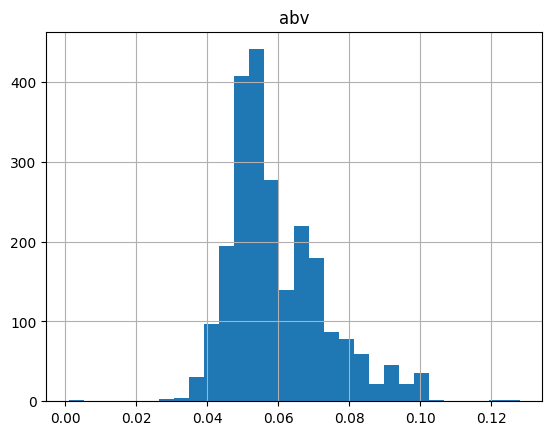

In [11]:
# Creating a histogram of the abv content

abv_hist = abv_distribution_result.hist(bins=30);

### **Q8. Query the distinct types of IPA styles in the `beers` table.**

- Use `DISTINCT()` function to extract unique IPA styles from `style` column and assign the alias `ipa_styles`

- To specify the criteria, you may want to use `LIKE` with the `WHERE` keyword. Extract all IPA styles from `style` column if it has the word `"IPA"` in its name

- Sort the data in alphabetical order, this could be achieved by using `ORDER BY` keyword with `ASC`


See below code syntax for some guidance:
```SQL
SELECT DISTINCT(column_name) AS <alias>
FROM beers
WHERE <condition>
ORDER BY <column_name> ASC;
```

In [12]:
# Finding the distinct ipa styles:

ipa_styles_query = """
SELECT DISTINCT(style) AS ipa_styles
FROM beers
WHERE style LIKE "%ipa%"
ORDER BY style ASC;
"""

ipa_styles_result = pd.read_sql_query(ipa_styles_query, conn)
ipa_styles_result

,ipa_styles
0,American Double / Imperial IPA
1,American IPA
2,American White IPA
3,Belgian IPA
4,English India Pale Ale (IPA)


The `ibu` is an abbreviation for the International Bitterness Units scale; a measurement of a beer's bitterness. Calculate the average bitterness of lager beers and pale ale beers. A beer style lager contains `"lager"`, and a beer style is pale ale if its style contains `"IPA"`, `"APA"` or `"Pale Ale"`.

In [13]:
#Finding the average iby for pale ales and lagers.

ale_bitterness_query = """
SELECT AVG(ibu)
FROM beers
WHERE style LIKE "%ipa%" OR style LIKE '%apa%' OR style LIKE '%pale ale%';
"""

ale_bitterness_result = pd.read_sql_query(ale_bitterness_query, conn)
print(ale_bitterness_result)

lager_bitterness_query = """
SELECT AVG(ibu)
FROM beers
WHERE style LIKE "%lager%";
"""

lager_bitterness_result = pd.read_sql_query(lager_bitterness_query, conn)
print(lager_bitterness_result)

    AVG(ibu)
0  63.353571
    AVG(ibu)
0  22.863636


In [14]:
# Calculating the number of beers there are of each style in the beers table. 

style_count_query = """
SELECT DISTINCT style, 
COUNT() OVER(PARTITION BY style) AS number
FROM beers
ORDER BY number DESC;
"""

style_count_result = pd.read_sql_query(style_count_query, conn)
style_count_result

,style,number
0,American IPA,424
1,American Pale Ale (APA),245
2,American Amber / Red Ale,133
3,American Blonde Ale,108
4,American Double / Imperial IPA,105
...,...,...
95,Kristalweizen,1
96,Low Alcohol Beer,1
97,Other,1
98,Smoked Beer,1


In [15]:
# Inner joining two tables to find all the breweries and beers that can be found in San Francisco

beers_and_brewery_query = """
SELECT beers.name AS beer, breweries.name AS brewery 
FROM beers
INNER JOIN breweries
ON beers.brewery_id = breweries.brewery_id
WHERE breweries.city = 'San Francisco'
ORDER BY brewery ASC, beer ASC;
"""

beers_and_brewery_result = pd.read_sql_query(beers_and_brewery_query, conn)
beers_and_brewery_result

,beer,brewery
0,21st Amendment IPA (2006),21st Amendment Brewery
1,21st Amendment Watermelon Wheat Beer (2006),21st Amendment Brewery
2,Back in Black,21st Amendment Brewery
3,Bitter American,21st Amendment Brewery
4,Bitter American (2011),21st Amendment Brewery
5,Brew Free! or Die IPA,21st Amendment Brewery
6,Brew Free! or Die IPA (2008),21st Amendment Brewery
7,Brew Free! or Die IPA (2009),21st Amendment Brewery
8,Fireside Chat,21st Amendment Brewery
9,Fireside Chat (2010),21st Amendment Brewery


**Q12. Query the `beers` and `breweries` tables to find the largest breweries by the number of beers produced.**

- Your result should have two columns, `name` and `number of beers`, and should be ordered from largest to smallest.

- If `number of beers` is the same, it should be ordered alphabetically.

- Limit your result to the top `10` breweries.

_Note: if a column name has spaces, you can wrap it in backticks(\` \`), quotes(" "), or square brackets(\[ \])._

_E.g. `SELECT [long column name] FROM table`_

_**Hint**:  some breweries have the same name, hence you cannot rely on unique names. ID numbers are often used unique identifiers for this reason._

Please note you have been provided with the code for this question to carry out the necessary data manipulation and reporting work. Simply run the code cell to produce the desired results.

In [16]:
# Querying both tables to find the largest breweries by number of beers produced:

largest_breweries_query = """
SELECT breweries.name AS name, COUNT(*) AS "number of beers"
FROM beers
INNER JOIN breweries
ON beers.brewery_id = breweries.brewery_id
GROUP BY breweries.brewery_id, breweries.name 
ORDER BY "number of beers" DESC, name ASC
LIMIT 10;
"""
largest_breweries_result = pd.read_sql_query(largest_breweries_query, conn)
largest_breweries_result

,name,number of beers
0,Brewery Vivant,62
1,Sun King Brewing Company,38
2,Oskar Blues Brewery,33
3,Cigar City Brewing Company,25
4,Sixpoint Craft Ales,24
5,Hopworks Urban Brewery,23
6,Stevens Point Brewery,22
7,21st Amendment Brewery,20
8,Great Crescent Brewery,20
9,Bonfire Brewing Company,19


**Q13. Query the `breweries` and `beers` tables to identify the top 10 US states with regard to the number of _breweries_.**


- Your result should have three columns: `state`, `breweries` (the number of breweries), and `beers` (the number of `beers`).

- Make sure you order your result by number of breweries to get the top 10 - if there is a draw order alphabetically by state


Please note you have been provided with the code for this question to carry out the necessary data manipulation and reporting work. Simply run the code cell to produce the desired results.

In [17]:
# Querying both tables to identify the top 10 US states with regard to the number of breweries:

top_10_states_query = """
SELECT
    brew.state AS state
    , COUNT(DISTINCT(brew.brewery_id)) AS breweries
    , COUNT(*) AS beers
FROM beers
JOIN breweries AS brew
ON beers.brewery_id = brew.brewery_id
GROUP BY state
ORDER BY breweries DESC, state ASC
LIMIT 10
"""
top_10_states_result = pd.read_sql_query(top_10_states_query, conn)
top_10_states_result

,state,breweries,beers
0,CO,47,265
1,CA,39,183
2,MI,32,162
3,OR,29,125
4,TX,28,130
5,PA,25,100
6,MA,23,82
7,WA,23,68
8,IN,22,139
9,WI,20,87


In [18]:
# A more flexible way of processing the same request, which is more flexible

top_10_states_query_2 = """
    SELECT state, count(*) AS "breweries", sum(b.beers) "beers" FROM breweries
    JOIN 
        (SELECT brewery_id, count(*) AS beers
         FROM beers
         GROUP BY brewery_id) b 
    ON b.brewery_id = breweries.brewery_id
    GROUP BY state
    ORDER BY breweries DESC, state ASC
    LIMIT 10
"""

top_10_states_result_2 = pd.read_sql_query(top_10_states_query_2, conn)
top_10_states_result_2

,state,breweries,beers
0,CO,47,265
1,CA,39,183
2,MI,32,162
3,OR,29,125
4,TX,28,130
5,PA,25,100
6,MA,23,82
7,WA,23,68
8,IN,22,139
9,WI,20,87
